In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("huanghanchina/pascal-voc-2012")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\liude\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1


In [2]:
import os

base_path = os.path.join(path, 'VOC2012')
csv_file = os.path.join(base_path, 'ImageSets/Segmentation/trainval.txt')
img_path = os.path.join(base_path, 'JPEGImages')
target_path = os.path.join(base_path, 'SegmentationClass')


In [3]:
img_files = os.listdir(img_path)
target_files = os.listdir(target_path)
print(len(img_files), len(target_files), img_files[:5], target_files[:5])

17125 2913 ['2007_000027.jpg', '2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg'] ['2007_000032.png', '2007_000033.png', '2007_000039.png', '2007_000042.png', '2007_000061.png']


In [4]:
with open(csv_file) as f:
    files = f.readlines()

files = [f.strip() for f in files]
files[:5]

['2007_000032', '2007_000033', '2007_000039', '2007_000042', '2007_000061']

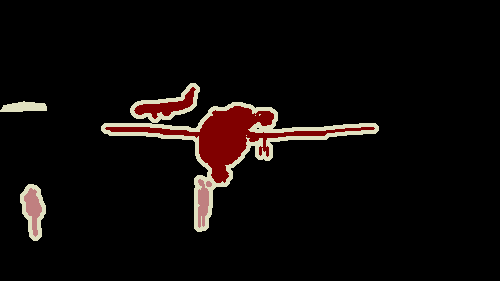

In [5]:
from PIL import Image


def get_img_target(img_file):
    img = Image.open(os.path.join(img_path, img_file + '.jpg'))
    target = Image.open(os.path.join(target_path, img_file + '.png'))
    return img, target


img, target = get_img_target(files[0])
target

In [24]:
import transforms as T


def cat_list(images, fill_value=0):
    # 这是不易读但高效的写法。
    # 同一个batch里的数据必须一样大。我们pad一个batch中的images为其中最大的大小。
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    batch_shape = (len(images),) + max_size
    batched_images = images[0].new(*batch_shape).fill_(fill_value)
    for img, pad_img in zip(images, batched_images):
        # 考虑到target的shape是[H,W]
        pad_img[..., : img.shape[-2], : img.shape[-1]].copy_(img)
    return batched_images


img1, targ1 = get_img_target(files[0])
img2, targ2 = get_img_target(files[1])

img1, _ = T.ToTensor()(img1, targ1)
img2, _ = T.ToTensor()(img2, targ2)

print(img1.shape, img2.shape)
imgs = cat_list([img1, img2])
print(imgs.shape)

torch.Size([3, 281, 500]) torch.Size([3, 366, 500])
torch.Size([2, 3, 366, 500])


In [25]:
from torch.utils.data import Dataset
from torchvision.transforms import functional as F


# VOC数据集，它需要transforms
class VOCSegmentationDataset(Dataset):
    def __init__(self, transforms=None):
        self.images = [os.path.join(img_path, f + '.jpg') for f in files]
        self.targets = [os.path.join(target_path, f + '.png') for f in files]
        self.transforms = transforms

    def __getitem__(self, index):
        img = Image.open(self.images[index])
        target = Image.open(self.targets[index])

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.images)

    @staticmethod
    def collate_fn(batch):
        images, targets = list(zip(*batch))
        batched_imgs = cat_list(images, fill_value=0)
        batched_targets = cat_list(targets, fill_value=255)
        return batched_imgs, batched_targets

In [26]:
class SegmentationPresetTrain:
    def __init__(self, base_size, crop_size, hflip=0.5, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        min_size = int(0.5 * base_size)
        max_size = int(2.0 * base_size)

        trans = [T.RandomResize(min_size, max_size)]

        if hflip > 0:
            trans.append(T.RandomHorizontalFlip(hflip))

        trans.extend([
            T.RandomCrop(crop_size),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ])

        self.transforms = T.Compose(trans)

    def __call__(self, img, target):
        return self.transforms(img, target)


class SegmentationPresetEval:
    def __init__(self, base_size, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.transforms = T.Compose([
            T.RandomResize(base_size),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ])

    def __call__(self, img, target):
        return self.transforms(img, target)


def get_transform(train):
    base_size = 520
    crop_size = 480

    return SegmentationPresetTrain(base_size, crop_size) if train else SegmentationPresetEval(base_size)

In [28]:
from torch.utils.data import DataLoader

train_dataset = VOCSegmentationDataset(transforms=get_transform(train=True))
val_dataset = VOCSegmentationDataset(transforms=get_transform(train=False))

batch_size = 16
num_workers = 0

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          num_workers=num_workers,
                          pin_memory=True,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        num_workers=num_workers,
                        pin_memory=True,
                        shuffle=False,
                        collate_fn=train_dataset.collate_fn)

In [46]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F

class FCN32s(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()

        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        for param in vgg.features.parameters():
            param.requires_grad = False

        # 得到的VGG16Backbone的输出为[batch_size, 512, H/32, W/32]
        self.backbone = vgg.features

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7),
            nn.BatchNorm2d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.BatchNorm2d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, num_classes, kernel_size=1)
        )

        # 上采样恢复到(num_cls, H, W), 即原图大小
        # self.upsample = nn.Sequential(
        #     nn.ConvTranspose2d(某些参数)
        # )
        # 本来upsample就是想学习一个上采样方法，对于这个模型直接使用bilinear插值来上采样即可

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        # x = self.upsample(x)
        
        # 原论文中虽然使用的是ConvTranspose2d，但权重是冻结的，所以就是一个bilinear插值
        upsample_factor = 32
        x = F.interpolate(x, scale_factor=upsample_factor, mode='bilinear', align_corners=False)
        

        return x


model = FCN32s()
x = torch.randn(2, 3, 512, 512)

x = model(x)
print(x.shape)

torch.Size([2, 21, 320, 320])


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=255)


In [47]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

n_epochs = 10
lr = 0.001
momentum = 0.9

params_to_optimize = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params_to_optimize, lr=lr, momentum=momentum)


def create_lr_scheduler(optimizer,
                        num_step: int,
                        epochs: int,
                        warmup=True,
                        warmup_epochs=1,
                        warmup_factor=1e-3):
    assert num_step > 0 and epochs > 0
    if warmup is False:
        warmup_epochs = 0

    def f(x):
        """
        根据step数返回一个学习率倍率因子，
        注意在训练开始之前，pytorch会提前调用一次lr_scheduler.step()方法
        """
        if warmup is True and x <= (warmup_epochs * num_step):
            alpha = float(x) / (warmup_epochs * num_step)
            # warmup过程中lr倍率因子从warmup_factor -> 1
            return warmup_factor * (1 - alpha) + alpha
        else:
            # warmup后lr倍率因子从1 -> 0
            # 参考deeplab_v2: Learning rate policy
            return (1 - (x - warmup_epochs * num_step) / ((epochs - warmup_epochs) * num_step)) ** 0.9

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=f)

lr_scheduler = create_lr_scheduler(optimizer, len(train_loader),epochs=n_epochs, warmup=True)


In [ ]:
for epoch in range(n_epochs):
    